In [7]:
import mne
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
import os
import re

# Multiprocessing
import deepgraph as dg
from multiprocessing import Pool


# Data Preparation

In [8]:
# Common funtions 
def get_pearson_matrix(raw, channels=None): 
    if (channels != None):
      ch = channels
    else:
      ch = raw.ch_names[:20]
    pearson = {} 

    for c in ch: 
        pearson[c] = {} 
        pearson[c][c] = 1
        
    _ch = ch.copy()
    while(len(_ch) > 0):
        chl1 = _ch.pop(0) 
        for chl2 in _ch:
            raw1, _ = raw[chl1]
            raw2, _ = raw[chl2]

            pearson_c = stats.pearsonr(raw1.flatten(), raw2.flatten())

            pearson[chl1][chl2] = pearson_c[0]
            pearson[chl2][chl1] = pearson_c[0]
    return pearson 


def get_eeg_file(unique_id): 
  rootdir = "./edf"
  sub,  taks = unique_id.split('_')
  regex = re.compile('(.*{}.*{}.*edf$)'.format(sub, taks))

  for root, dirs, files in os.walk(rootdir):
    for file in files:
      if regex.match(file):
        return file

In [9]:
get_eeg_file("9003_RSEC")

'INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEC_01.edited.18.134.318.132.edf'

In [10]:
df = pd.read_excel("Demographic_List.xlsx")

df.head(10)

,sub,Age,Gender,Study,count,session,Condition,task,Headset
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24
5,9006,52,M,INSPECDS,291,900601000,HC,RSEO,X24
6,9008,53,F,INSPECDS,291,900801000,HC,RSEC,X24
7,9008,53,F,INSPECDS,290,900801000,HC,RSEO,X24
8,9009,48,F,INSPECDS,292,900901000,HC,RSEC,X24
9,9009,48,F,INSPECDS,279,900901000,HC,RSEO,X24


In [12]:
df.groupby("Condition").count()

,sub,Age,Gender,Study,count,session,task,Headset
Condition,,,,,,,,
AD,52,52,52,52,52,52,52,52
HC,224,224,224,224,224,224,224,224
MCI,107,107,107,107,107,107,107,107


In [13]:
conditions = set(df["Condition"])
conditions

{'AD', 'HC', 'MCI'}

In [14]:
df["unique_id"] = df["sub"].astype(str) + "_" + df["task"]
df

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24,9003_RSEC
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24,9003_RSEO
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24,9004_RSEC
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24,9004_RSEO
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24,9006_RSEC
...,...,...,...,...,...,...,...,...,...,...
378,9807,59,F,INSPECDS,292,980701000,MCI,RSEO,X24,9807_RSEO
379,9809,77,M,INSPECDS,288,980901000,MCI,RSEC,X24,9809_RSEC
380,9809,77,M,INSPECDS,284,980901000,MCI,RSEO,X24,9809_RSEO
381,9812,75,M,INSPECDS,290,981211000,MCI,RSEC,X24,9812_RSEC


In [15]:
df["filename"] = df["unique_id"].apply(get_eeg_file)
df

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id,filename
0,9003,41,F,INSPECDS,286,900301000,HC,RSEC,X24,9003_RSEC,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
1,9003,41,F,INSPECDS,296,900301000,HC,RSEO,X24,9003_RSEO,INSPEC.INIT.900301000.010217.104300.Signals.Ra...
2,9004,66,F,INSPECDS,266,900401000,HC,RSEC,X24,9004_RSEC,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
3,9004,66,F,INSPECDS,285,900401000,HC,RSEO,X24,9004_RSEO,INSPEC.INIT.900401000.070217.105622.Signals.Ra...
4,9006,52,M,INSPECDS,288,900601000,HC,RSEC,X24,9006_RSEC,INSPEC.INIT.900601000.130217.115256.Signals.Ra...
...,...,...,...,...,...,...,...,...,...,...,...
378,9807,59,F,INSPECDS,292,980701000,MCI,RSEO,X24,9807_RSEO,INSPEC.INIT.980701000.070619.062930.Signals.Ra...
379,9809,77,M,INSPECDS,288,980901000,MCI,RSEC,X24,9809_RSEC,INSPEC.INIT.980901000.170719.150050.Signals.Ra...
380,9809,77,M,INSPECDS,284,980901000,MCI,RSEO,X24,9809_RSEO,INSPEC.INIT.980901000.170719.150050.Signals.Ra...
381,9812,75,M,INSPECDS,290,981211000,MCI,RSEC,X24,9812_RSEC,INSPEC.INIT.981211000.290819.083316.Signals.Ra...


In [16]:
df_AD = df[df["Condition"] == "AD"]
df_AD.head(5)

,sub,Age,Gender,Study,count,session,Condition,task,Headset,unique_id,filename
200,9202,83,F,INSPECDS,286,920201000,AD,RSEC,X24,9202_RSEC,INSPEC.INIT.920201000.140317.103730.Signals.Ra...
201,9202,83,F,INSPECDS,283,920201000,AD,RSEO,X24,9202_RSEO,INSPEC.INIT.920201000.140317.103730.Signals.Ra...
206,9205,90,M,INSPECDS,259,920501000,AD,RSEC,X24,9205_RSEC,INSPEC.INIT.920501000.280317.110637.Signals.Ra...
207,9205,90,M,INSPECDS,240,920501000,AD,RSEO,X24,9205_RSEO,INSPEC.INIT.920501000.280317.110637.Signals.Ra...
208,9206,59,F,INSPECDS,287,920601000,AD,RSEC,X24,9206_RSEC,INSPEC.INIT.920601000.050417.122248.Signals.Ra...


In [17]:
def get_raw_eeg(filename, root_dir = "./edf/"):
    raw = mne.io.read_raw_edf(root_dir + filename)
    return raw

In [20]:
df = df[df["Condition"] != "MCI"]

In [36]:
df.to_csv("dataframe.csv")

In [21]:
# Read EEG raw files and save them in a dict for later use 
raw_files = {} 
eeg_min_size = 308224
for _, s in df.iterrows(): 
    raw_files[s["unique_id"]] = get_raw_eeg(s["filename"])
    shape = raw_files[s["unique_id"]].get_data().shape[1] 
    eeg_min_size = shape if shape < eeg_min_size else eeg_min_size

eeg_min_size

Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\edf\INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEC_01.edited.18.134.318.132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\edf\INSPEC.INIT.900301000.010217.104300.Signals.Raw_RSEO_01.edited.47.187.347.192.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\edf\INSPEC.INIT.900401000.070217.105622.Signals.Raw_RSEC_01.edited.25.108.325.112.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\CNU\EEG\edf\INSPEC.INIT.900401000.070217.105622.Signals.Raw_RSEO_01.edited.347.72.647.76.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\jimmy\Documents\C

285696

In [22]:
eeg_max_size = 308224
n_features = 20
n_samples = len(raw_files) 
channels = raw_files["9003_RSEC"].ch_names[:20]

X = np.zeros((n_samples, n_features, eeg_max_size))
X.shape

(276, 20, 308224)

In [23]:
# Fill matrix X with data 
for i, item in enumerate(raw_files.items()): 
    key, value = item 
    shape = value.get_data().shape[1]
    data = value.get_data(channels) 
    data = np.pad(data, [(0,0),(0, eeg_max_size-shape )], 'wrap')
    X[i] += data

In [25]:
X.shape

(276, 20, 308224)

In [27]:
np.save('samples', X)

In [28]:
X = np.load('samples.npy')

In [29]:
# Calculate and store Correlations 
from nancorrmp.nancorrmp import NaNCorrMp
X_corr = np.zeros((X.shape[0], X.shape[1], X.shape[1] ))
p_corr = np.zeros(X_corr.shape)

for i in range(X.shape[0]):
    corr, p = NaNCorrMp.calculate_with_p_value(X[i],  n_jobs=5)
    X_corr[i] += corr
    p_corr[i] += p

In [30]:
p_corr

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [31]:
X_corr.shape

(276, 20, 20)

In [32]:
X_corr

array([[[1.        , 0.86084125, 0.44893829, ..., 0.62664501,
         0.57631255, 0.31756777],
        [0.86084125, 1.        , 0.28758012, ..., 0.73915388,
         0.61169936, 0.35971843],
        [0.44893829, 0.28758012, 1.        , ..., 0.50759986,
         0.66628074, 0.54512405],
        ...,
        [0.62664501, 0.73915388, 0.50759986, ..., 1.        ,
         0.85907675, 0.68124747],
        [0.57631255, 0.61169936, 0.66628074, ..., 0.85907675,
         1.        , 0.69146781],
        [0.31756777, 0.35971843, 0.54512405, ..., 0.68124747,
         0.69146781, 1.        ]],

       [[1.        , 0.94110821, 0.90906576, ..., 0.90437026,
         0.90396797, 0.87365477],
        [0.94110821, 1.        , 0.94066784, ..., 0.97923898,
         0.97447078, 0.96695621],
        [0.90906576, 0.94066784, 1.        , ..., 0.91545145,
         0.91636993, 0.90273017],
        ...,
        [0.90437026, 0.97923898, 0.91545145, ..., 1.        ,
         0.99234116, 0.99279845],
        [0.9

In [33]:
sns.heatmap(X_corr[0])

<AxesSubplot:>

In [34]:
np.save('samples_corr', X_corr)
np.save('p_values', p_corr)

<AxesSubplot:>

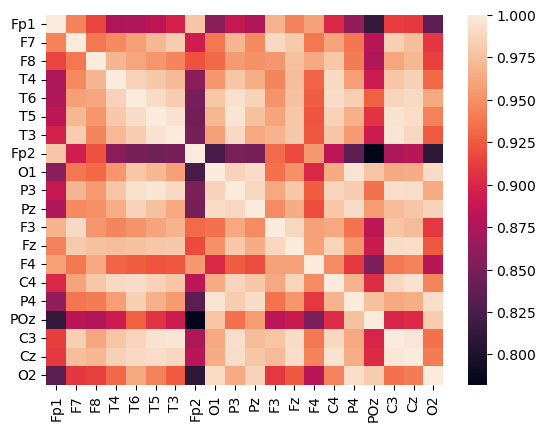

In [91]:
sns.heatmap(pd.DataFrame(matrix.get(201)))

<AxesSubplot:>

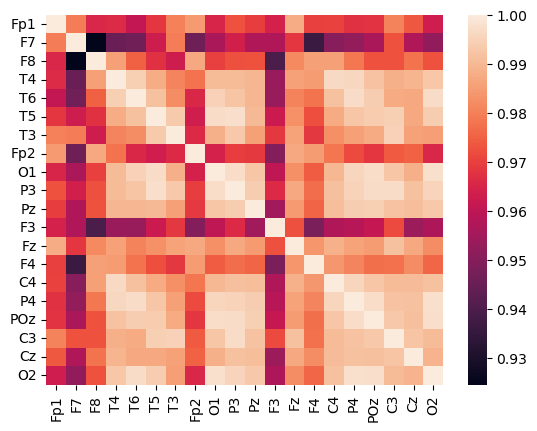

In [96]:
sns.heatmap(pd.DataFrame(matrix.get(206)))

# Paper Dataset